In [1]:
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import mobilenet_v3
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report,confusion_matrix
print(device_lib.list_local_devices())

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17503376247717589969
]
2.6.0
Num GPUs Available:  0


In [4]:
def get_data_color(data_dir, labels):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv.imread(os.path.join(path, img), cv.IMREAD_COLOR)[...,::-1]
                resized_arr = cv.resize(img_arr, (img_size, img_size))
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [19]:
def get_data_gray(data_dir, labels):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv.imread(os.path.join(path, img), cv.IMREAD_GRAYSCALE)
                img_arr = np.expand_dims(img_arr, -1)
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [24]:
labels = ['type_2', 'type_3', 'type_4']
img_size = 256
train_path = '/home/vkorneychuk/projects/lum/photo/03.11/white/blades/train'
test_path = '/home/vkorneychuk/projects/lum/photo/03.11/white/blades/test'

train = get_data_color(train_path, labels)
val = get_data_color(test_path, labels)

print(train[1][0].shape)

l = []
for i in train:
    if(i[1] == 0):
        l.append("type_2")
    elif (i[1] == 1):
        l.append("type_3")
    elif (i[1] == 2):
        l.append("type_4")

(256, 256, 3)


<ipython-input-23-98fc425b153a>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [36]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

print(x_train.shape)
print(x_val.shape)

# For color
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

(693, 256, 256, 3)
(171, 256, 256, 3)


In [37]:
print(x_train.shape)

(693, 256, 256, 3)


In [38]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [39]:
model = Sequential()
#COLOR
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))
#GRAYSCALE
#model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,1)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(3, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)       

In [40]:
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

In [41]:
history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))

Epoch 1/500


/home/vkorneychuk/.local/lib/python3.8/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


22/22 [==============================] - 7s 141ms/step - loss: 1.1046 - accuracy: 0.3232 - val_loss: 1.0993 - val_accuracy: 0.3158
Epoch 2/500
22/22 [==============================] - 1s 68ms/step - loss: 1.1019 - accuracy: 0.3478 - val_loss: 1.0984 - val_accuracy: 0.3450
Epoch 3/500
22/22 [==============================] - 2s 69ms/step - loss: 1.0967 - accuracy: 0.3622 - val_loss: 1.0973 - val_accuracy: 0.3509
Epoch 4/500
22/22 [==============================] - 1s 68ms/step - loss: 1.0964 - accuracy: 0.3737 - val_loss: 1.0968 - val_accuracy: 0.3450
Epoch 5/500
22/22 [==============================] - 2s 69ms/step - loss: 1.0957 - accuracy: 0.3636 - val_loss: 1.0960 - val_accuracy: 0.3626
Epoch 6/500
22/22 [==============================] - 2s 69ms/step - loss: 1.0981 - accuracy: 0.3290 - val_loss: 1.0953 - val_accuracy: 0.3743
Epoch 7/500
22/22 [==============================] - 2s 69ms/step - loss: 1.0963 - accuracy: 0.3535 - val_loss: 1.0946 - val_accuracy: 0.4094
Epoch 8/500
22/22

22/22 [==============================] - 2s 69ms/step - loss: 0.9116 - accuracy: 0.6465 - val_loss: 0.9374 - val_accuracy: 0.6550
Epoch 116/500
22/22 [==============================] - 2s 69ms/step - loss: 0.9080 - accuracy: 0.6364 - val_loss: 0.9356 - val_accuracy: 0.6725
Epoch 117/500
22/22 [==============================] - 2s 73ms/step - loss: 0.9120 - accuracy: 0.6349 - val_loss: 0.9341 - val_accuracy: 0.6608
Epoch 118/500
22/22 [==============================] - 2s 77ms/step - loss: 0.9036 - accuracy: 0.6522 - val_loss: 0.9324 - val_accuracy: 0.6550
Epoch 119/500
22/22 [==============================] - 1s 68ms/step - loss: 0.9065 - accuracy: 0.6263 - val_loss: 0.9306 - val_accuracy: 0.6784
Epoch 120/500
22/22 [==============================] - 1s 67ms/step - loss: 0.9016 - accuracy: 0.6436 - val_loss: 0.9296 - val_accuracy: 0.6608
Epoch 121/500
22/22 [==============================] - 1s 67ms/step - loss: 0.9063 - accuracy: 0.6349 - val_loss: 0.9276 - val_accuracy: 0.6725
Epoch 

Epoch 172/500
22/22 [==============================] - 2s 76ms/step - loss: 0.8205 - accuracy: 0.7027 - val_loss: 0.8531 - val_accuracy: 0.7251
Epoch 173/500
22/22 [==============================] - 2s 75ms/step - loss: 0.8243 - accuracy: 0.6912 - val_loss: 0.8522 - val_accuracy: 0.7135
Epoch 174/500
22/22 [==============================] - 2s 73ms/step - loss: 0.8117 - accuracy: 0.7085 - val_loss: 0.8507 - val_accuracy: 0.7018
Epoch 175/500
22/22 [==============================] - 2s 68ms/step - loss: 0.8102 - accuracy: 0.7085 - val_loss: 0.8490 - val_accuracy: 0.7310
Epoch 176/500
22/22 [==============================] - 1s 68ms/step - loss: 0.8144 - accuracy: 0.7100 - val_loss: 0.8479 - val_accuracy: 0.7135
Epoch 177/500
22/22 [==============================] - 1s 68ms/step - loss: 0.8095 - accuracy: 0.7302 - val_loss: 0.8464 - val_accuracy: 0.7310
Epoch 178/500
22/22 [==============================] - 1s 68ms/step - loss: 0.8114 - accuracy: 0.7157 - val_loss: 0.8448 - val_accuracy:

Epoch 229/500
22/22 [==============================] - 1s 68ms/step - loss: 0.7545 - accuracy: 0.7605 - val_loss: 0.7804 - val_accuracy: 0.7895
Epoch 230/500
22/22 [==============================] - 2s 69ms/step - loss: 0.7443 - accuracy: 0.7532 - val_loss: 0.7800 - val_accuracy: 0.7778
Epoch 231/500
22/22 [==============================] - 1s 68ms/step - loss: 0.7335 - accuracy: 0.7677 - val_loss: 0.7780 - val_accuracy: 0.8012
Epoch 232/500
22/22 [==============================] - 1s 68ms/step - loss: 0.7441 - accuracy: 0.7489 - val_loss: 0.7777 - val_accuracy: 0.7719
Epoch 233/500
22/22 [==============================] - 1s 67ms/step - loss: 0.7353 - accuracy: 0.7706 - val_loss: 0.7757 - val_accuracy: 0.7953
Epoch 234/500
22/22 [==============================] - 1s 68ms/step - loss: 0.7323 - accuracy: 0.7720 - val_loss: 0.7746 - val_accuracy: 0.7895
Epoch 235/500
22/22 [==============================] - 2s 70ms/step - loss: 0.7279 - accuracy: 0.7662 - val_loss: 0.7734 - val_accuracy:

Epoch 286/500
22/22 [==============================] - 1s 68ms/step - loss: 0.6790 - accuracy: 0.7922 - val_loss: 0.7164 - val_accuracy: 0.8304
Epoch 287/500
22/22 [==============================] - 1s 68ms/step - loss: 0.6748 - accuracy: 0.8283 - val_loss: 0.7151 - val_accuracy: 0.8304
Epoch 288/500
22/22 [==============================] - 1s 68ms/step - loss: 0.6736 - accuracy: 0.8095 - val_loss: 0.7141 - val_accuracy: 0.8304
Epoch 289/500
22/22 [==============================] - 1s 68ms/step - loss: 0.6695 - accuracy: 0.8023 - val_loss: 0.7130 - val_accuracy: 0.8363
Epoch 290/500
22/22 [==============================] - 1s 68ms/step - loss: 0.6688 - accuracy: 0.8124 - val_loss: 0.7119 - val_accuracy: 0.8363
Epoch 291/500
22/22 [==============================] - 1s 68ms/step - loss: 0.6711 - accuracy: 0.7980 - val_loss: 0.7104 - val_accuracy: 0.8129
Epoch 292/500
22/22 [==============================] - 2s 71ms/step - loss: 0.6683 - accuracy: 0.8081 - val_loss: 0.7113 - val_accuracy:

Epoch 343/500
22/22 [==============================] - 2s 74ms/step - loss: 0.6157 - accuracy: 0.8297 - val_loss: 0.6560 - val_accuracy: 0.8363
Epoch 344/500
22/22 [==============================] - 2s 72ms/step - loss: 0.6201 - accuracy: 0.8254 - val_loss: 0.6553 - val_accuracy: 0.8596
Epoch 345/500
22/22 [==============================] - 2s 73ms/step - loss: 0.6132 - accuracy: 0.8283 - val_loss: 0.6562 - val_accuracy: 0.8363
Epoch 346/500
22/22 [==============================] - 2s 75ms/step - loss: 0.6094 - accuracy: 0.8398 - val_loss: 0.6545 - val_accuracy: 0.8363
Epoch 347/500
22/22 [==============================] - 2s 72ms/step - loss: 0.6147 - accuracy: 0.8240 - val_loss: 0.6528 - val_accuracy: 0.8363
Epoch 348/500
22/22 [==============================] - 2s 76ms/step - loss: 0.6123 - accuracy: 0.8167 - val_loss: 0.6512 - val_accuracy: 0.8538
Epoch 349/500
22/22 [==============================] - 2s 75ms/step - loss: 0.6014 - accuracy: 0.8355 - val_loss: 0.6511 - val_accuracy:

Epoch 400/500
22/22 [==============================] - 2s 75ms/step - loss: 0.5635 - accuracy: 0.8456 - val_loss: 0.6028 - val_accuracy: 0.8596
Epoch 401/500
22/22 [==============================] - 2s 70ms/step - loss: 0.5562 - accuracy: 0.8499 - val_loss: 0.6020 - val_accuracy: 0.8655
Epoch 402/500
22/22 [==============================] - 2s 74ms/step - loss: 0.5593 - accuracy: 0.8514 - val_loss: 0.6018 - val_accuracy: 0.8713
Epoch 403/500
22/22 [==============================] - 2s 70ms/step - loss: 0.5593 - accuracy: 0.8499 - val_loss: 0.6000 - val_accuracy: 0.8772
Epoch 404/500
22/22 [==============================] - 2s 71ms/step - loss: 0.5460 - accuracy: 0.8730 - val_loss: 0.5997 - val_accuracy: 0.8538
Epoch 405/500
22/22 [==============================] - 2s 69ms/step - loss: 0.5568 - accuracy: 0.8514 - val_loss: 0.5989 - val_accuracy: 0.8538
Epoch 406/500
22/22 [==============================] - 2s 69ms/step - loss: 0.5574 - accuracy: 0.8254 - val_loss: 0.5974 - val_accuracy:

Epoch 457/500
22/22 [==============================] - 1s 68ms/step - loss: 0.5191 - accuracy: 0.8543 - val_loss: 0.5563 - val_accuracy: 0.8830
Epoch 458/500
22/22 [==============================] - 2s 72ms/step - loss: 0.5184 - accuracy: 0.8600 - val_loss: 0.5558 - val_accuracy: 0.8655
Epoch 459/500
22/22 [==============================] - 2s 70ms/step - loss: 0.5087 - accuracy: 0.8745 - val_loss: 0.5530 - val_accuracy: 0.8947
Epoch 460/500
22/22 [==============================] - 2s 69ms/step - loss: 0.5066 - accuracy: 0.8903 - val_loss: 0.5562 - val_accuracy: 0.8713
Epoch 461/500
22/22 [==============================] - 2s 69ms/step - loss: 0.5131 - accuracy: 0.8586 - val_loss: 0.5511 - val_accuracy: 0.8947
Epoch 462/500
22/22 [==============================] - 1s 68ms/step - loss: 0.5098 - accuracy: 0.8672 - val_loss: 0.5521 - val_accuracy: 0.8713
Epoch 463/500
22/22 [==============================] - 2s 70ms/step - loss: 0.5087 - accuracy: 0.8817 - val_loss: 0.5506 - val_accuracy:

In [42]:
#model = keras.models.load_model("my_h5_model.h5")
model.save("blade_model_test_2(color).h5")

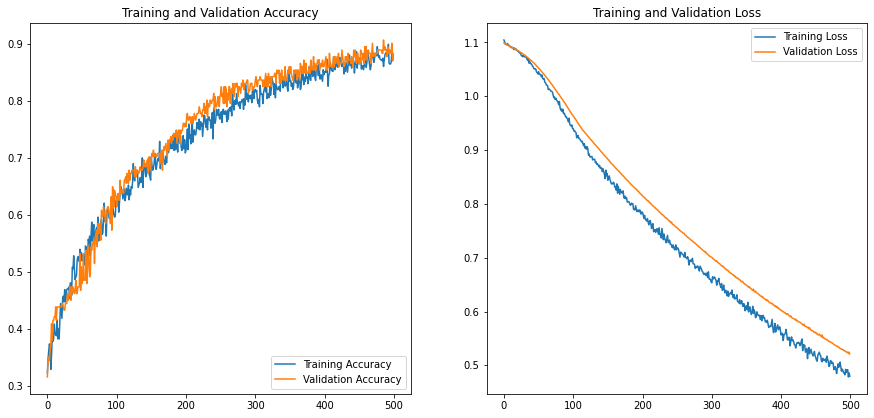

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Text(0.5, 1.0, 'Predict: type_3; Right: type_2')

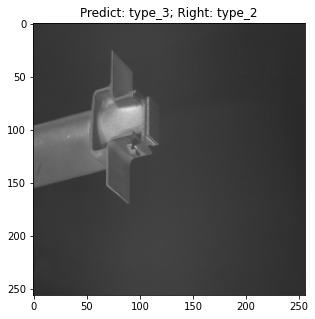

In [44]:
idx = 9
test_val = x_val[idx]
predictions = model.predict(np.array([test_val]))
plt.figure(figsize = (5,5))
plt.imshow(test_val)
plt.title('Predict: {}; Right: {}'.format(labels[np.argmax(predictions)], labels[y_val[idx]]))

In [45]:
predictions = model.predict(x_val)
rights = np.sum(np.argmax(predictions, axis=1) == y_val)
all = len(y_val)
print(rights/all)

0.8830409356725146


In [47]:
base_model = tf.keras.applications.VGG19(input_shape = (256, 256, 3), include_top = False)